In [23]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from datetime import timedelta, date
from workalendar.usa import new_york
from scipy.stats import pearsonr
import pickle
import warnings
warnings.filterwarnings('ignore')

Напомню, что результат Q_may ~= 17.5 на неделе 5. На неделе 4 ~= 27-34.

In [2]:
# df = pd.DataFrame()
# data = pd.read_csv('./TAXI DATA/CSVs/agr_2015.csv', sep=';')
# data.index = pd.to_datetime(data.index)
# data1= pd.read_csv('./TAXI DATA/CSVs/agr_2016.csv', sep=';')
# data1.index = pd.to_datetime(data1.index)
# df = pd.concat([df,data,data1], axis=0)
# df.head()

In [3]:
paths = ['./TAXI DATA/CSVs/agr_2015.csv','./TAXI DATA/CSVs/agr_2016.csv']

In [4]:
agr_data = pd.DataFrame()
for path in paths:
    data = pd.read_csv(path, sep=',')
    data.set_index('dt', inplace=True)
    data.index = pd.to_datetime(data.index)
    agr_data = pd.concat([agr_data,data], axis=0)
agr_data.head()

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
dt,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#sep for may
df_may = agr_data.loc['2016-05-01 00:00:00':'2016-05-31 23:00:00']
print((df_may.mean() > 5).sum())
print(df_may.shape)

102
(744, 2500)


In [6]:
main_columns = df_may.loc[:, df_may.mean() > 5].columns
main_columns

Index(['1076', '1077', '1078', '1126', '1127', '1128', '1129', '1130', '1131',
       '1132',
       ...
       '1631', '1685', '1734', '1735', '1784', '2069', '2070', '2119', '2120',
       '2169'],
      dtype='object', length=102)

In [7]:
filter_data = agr_data.loc[:,agr_data.columns.str.contains('|'.join(main_columns))]
col = [str(int(item)-1) for item in filter_data.columns]
filter_data.columns = col
filter_data.head(2)

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
dt,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,102.0,115.0,60.0,103.0,305.0,479.0,499.0,716.0,987.0,324.0,...,14.0,0.0,1.0,40.0,37.0,33.0,5.0,97.0,9.0,71.0
2015-01-01 01:00:00,134.0,162.0,56.0,134.0,474.0,513.0,449.0,483.0,630.0,228.0,...,23.0,0.0,1.0,0.0,4.0,4.0,0.0,110.0,0.0,2.0


In [8]:
# append feachers
data = filter_data.copy()

In [9]:
# copy method from week5
# месяц, день месяца, день недели, чаc
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['day of week'] = data.index.dayofweek
data['hour'] = data.index.hour

# годовые, месячные и суточные признаки Фурье
K = 60
year_period = 8766 #365.2424*24 - средняя продолжительность года в часах
week_period = 168 #24*7
day_period = 24
for i in range(1, K+1):
    data['y_с_' + str(i)] = np.cos(np.arange(1, data.shape[0]+1)*2*np.pi*i/year_period)
    data['y_s_' + str(i)] = np.sin(np.arange(1, data.shape[0]+1)*2*np.pi*i/year_period)
for i in range(1, K+1):    
    data['w_с_' + str(i)] = np.cos(np.arange(1, data.shape[0]+1)*2*np.pi*i/week_period)
    data['w_s_' + str(i)] = np.sin(np.arange(1, data.shape[0]+1)*2*np.pi*i/week_period)
for i in range(1, K+1):    
    data['d_с_' + str(i)] = np.cos(np.arange(1, data.shape[0]+1)*2*np.pi*i/day_period)
    data['d_s_' + str(i)] = np.sin(np.arange(1, data.shape[0]+1)*2*np.pi*i/day_period)   

По результат предварительных тестов, эти данные не улучшили решение. Поэтому исключаем их.

Выделим и обработаем следующие признаки за 2016-01/2016-06:
* Средняя протяженность поездок
* Среднее число пассажиров
* Средняя стоимость поездки

(Агрегировал на первой неделе, чтобы не захламлять, просто вставлю файлом сюда)

In [10]:
files = ['./TAXI DATA/CSVs/agr_2016_mean_passenger_count.csv','./TAXI DATA/CSVs/agr_2016_mean_total_amount.csv','./TAXI DATA/CSVs/agr_2016_mean_trip_distance.csv']
def dt_load(file):
    raw = pd.read_csv(file, sep=',')
    raw.set_index('dt', inplace=True)
    raw.index = pd.to_datetime(raw.index)
    fldt = raw.loc[:,raw.columns.str.contains('|'.join(main_columns))]
    clm_name =  [str(int(item)-1) for item in fldt.columns]
    fldt.columns = clm_name
    return fldt

In [11]:
mean_passenger_count = dt_load(files[0])
mean_total_amount = dt_load(files[1])
mean_trip_distance = dt_load(files[2])

In [12]:
#holidays
time_table = new_york.NewYork()

In [13]:
calendar = pd.DataFrame(filter_data.index)
calendar['working_day']=[int(time_table.is_working_day(x)) for x in calendar.dt]
calendar['holiday']=[int(time_table.is_holiday(x)) for x in calendar.dt]
calendar.set_index('dt',inplace=True)
calendar.head()

,working_day,holiday
dt,,
2015-01-01 00:00:00,0,1
2015-01-01 01:00:00,0,1
2015-01-01 02:00:00,0,1
2015-01-01 03:00:00,0,1
2015-01-01 04:00:00,0,1


Создадим нумерацию кластеров временных
Дабы сократить ненужные писания, воспользуемся функциями с 4ой недели курса 6. Kmeans и силуэтный анализ

In [14]:
def plot_silhouette(method, data, n_clusters):
    res = method.fit_predict(data)
    sil = silhouette_samples(data, res)
    silhouette_avg = silhouette_score(data, res)
    y_lower = 10

    fig, ax = plt.subplots()
    fig.set_size_inches(10, 4)

    ax.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sil[res == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        spectral_color = cm.get_cmap("Spectral")
        color = spectral_color(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

        ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()
def optimal_clusters_division(method, data, max_n_clusters, print_answer = False):
    score_list = []
    for n_clusters in range(2, max_n_clusters+1):
        res = method(n_clusters = n_clusters).fit_predict(data)
        score = silhouette_score(data, res)
        score_list.append(score)
    if print_answer == True:            
        print ('Max coef silc = {}. Count clasters = {}'.format(max(score_list), score_list.index(max(score_list))+2))
        return 
    return score_list   

In [15]:
scaler = StandardScaler()
scaler_data = pd.DataFrame(scaler.fit_transform(filter_data),
                          columns = filter_data.columns,
                          index = filter_data.index)
max_n_clusters = 10
scaler_data.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
dt,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,0.916989,-0.250716,-0.454114,0.851674,1.155650,1.400608,1.091287,1.788419,2.244059,2.202193,...,1.722949,-0.890961,-1.011038,-1.088848,-1.009355,-0.949889,-0.558485,-0.522199,-0.927907,0.205221
2015-01-01 01:00:00,1.696710,0.325060,-0.520931,1.620086,2.843203,1.637341,0.804559,0.633878,0.818469,1.018109,...,3.515838,-0.890961,-1.011038,-1.345927,-1.260750,-1.441944,-1.148246,-0.348986,-1.204609,-1.577419
2015-01-01 02:00:00,0.843890,0.533319,-0.804906,1.446574,1.824680,0.913215,0.471956,0.435674,0.199515,0.426067,...,8.496083,-0.890961,-0.815307,-1.339500,-1.275987,-1.509813,-1.148246,-1.748013,-1.204609,-1.603255
2015-01-01 03:00:00,0.380931,-0.238466,-1.138994,0.256774,1.355360,1.275278,0.036130,0.296931,-0.359540,0.167049,...,5.707145,-0.890961,-0.619576,-1.345927,-1.291223,-1.492846,-1.148246,-1.548152,-1.204609,-1.629090
2015-01-01 04:00:00,-0.959214,-0.998000,-1.205812,0.008899,-0.172424,0.286567,-0.198987,0.044220,-0.215783,-0.165974,...,6.503985,-0.890961,-0.228114,-1.333073,-1.268368,-1.441944,-1.148246,-1.774661,-1.204609,-1.215724


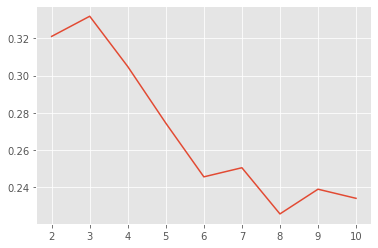

In [16]:
plt.plot(np.arange(2, max_n_clusters+1), optimal_clusters_division(KMeans, scaler_data,max_n_clusters))

Выглядит неплохо. 8 кластеров можно было бы сделать, но останемся на 10. Теоретически, можно будет построить дендрограмму и проверить.

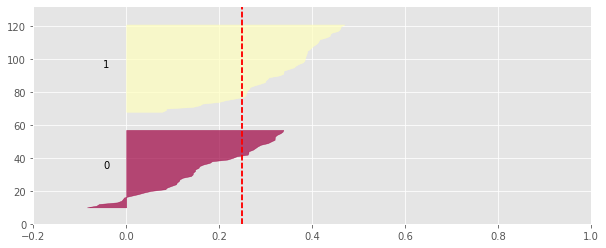

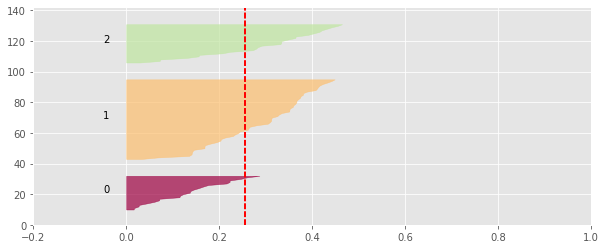

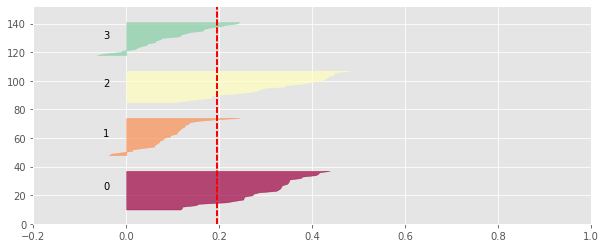

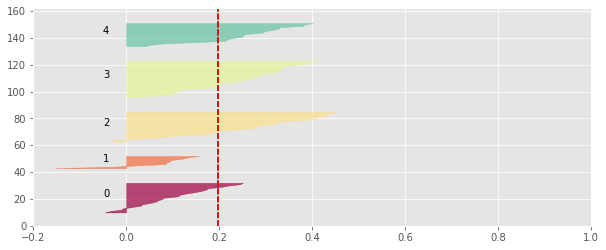

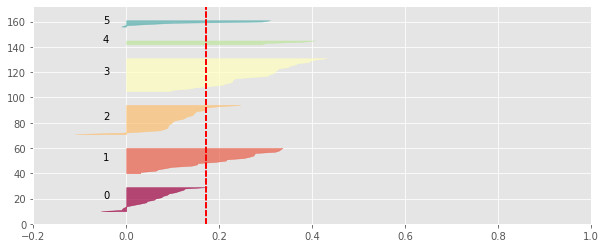

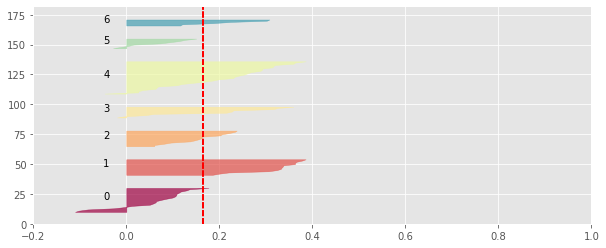

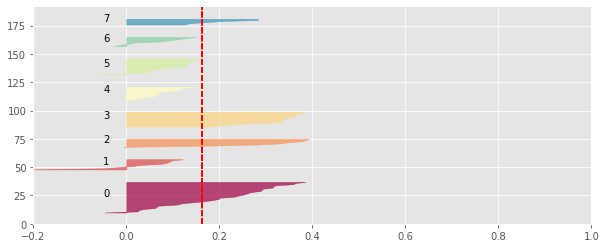

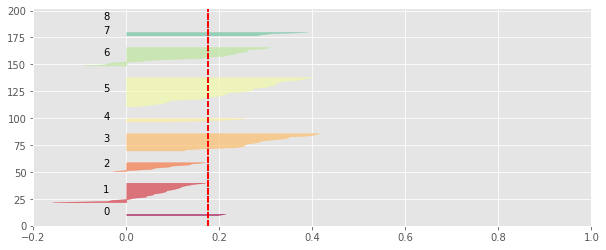

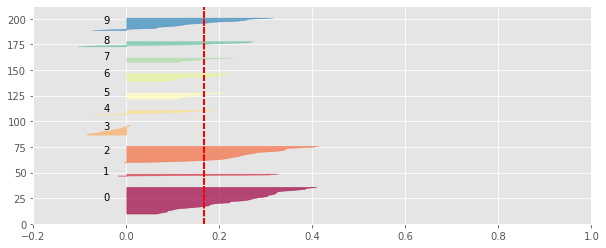

In [17]:
for n_clusters in range(2,max_n_clusters+1):
    plot_silhouette(KMeans(n_clusters=n_clusters), scaler_data.T, n_clusters)

Всё-таки остановимся на 8. RS = 42

In [18]:
cluster_model = KMeans(n_clusters=8, random_state=42)
res = cluster_model.fit_predict(filter_data)
np.unique(res, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([2564, 3019, 1358, 2024,  520, 1136,  924, 1583], dtype=int64))

In [19]:
cluster_numbers = pd.DataFrame(filter_data.index)
cluster_numbers.set_index('dt', inplace=True)
cluster_numbers['label'] = res
cluster_numbers.head(5)

,label
dt,
2015-01-01 00:00:00,6
2015-01-01 01:00:00,5
2015-01-01 02:00:00,5
2015-01-01 03:00:00,6
2015-01-01 04:00:00,2


Оценка признаков. Подбор модели. Далее будм пробовать моделью RidgeRegression, так как оптимальный по времени и качеству.

In [27]:
%%time 
#5 week 
data = pd.concat([data, cluster_numbers, calendar],axis=1)

linear_models_dict = {}

X_val_dict = {}
y_val_dict = {}
y_val_pred_dict = {}

X_test_dict = {}
y_test_dict = {}
y_test_pred_dict = {}

for id_name in filter_data.columns:
    print(id_name)
    drop_list = list(filter_data.columns)
    drop_list.remove(str(id_name))
    named_data = data.copy().drop(drop_list, axis = 1) #Избавляемся от лишних id на итерации
    
    #Добавляем shift признаки
    named_data['shift_1'] = named_data[str(id_name)].shift(1)
    named_data['shift_2'] = named_data[str(id_name)].shift(2)
    named_data['shift_3'] = named_data[str(id_name)].shift(3)
    named_data['shift_4'] = named_data[str(id_name)].shift(4)
    named_data['shift_5'] = named_data[str(id_name)].shift(5)
    named_data['shift_6'] = named_data[str(id_name)].shift(6)
    
    named_data['shift_7'] = named_data[str(id_name)].shift(7)
    named_data['shift_8'] = named_data[str(id_name)].shift(8)
    named_data['shift_9'] = named_data[str(id_name)].shift(9)
    named_data['shift_10'] = named_data[str(id_name)].shift(10)
    named_data['shift_11'] = named_data[str(id_name)].shift(11) 
    named_data['shift_12'] = named_data[str(id_name)].shift(12)   
        
    
    named_data['shift_24'] = named_data[str(id_name)].shift(24)
    named_data['shift_48'] = named_data[str(id_name)].shift(48)
    
    named_data = named_data.iloc[48:]
    
    # Разбиение данных
    predict_may_start = '2016-04-30 23:00'
    predict_may_stop = '2016-05-31 23:00'
    precit_june_stop = '2016-06-30 23:00' # df и так заканчивается этим числом
    
    X_train = named_data.loc[:predict_may_start].drop(str(id_name), axis = 1)
    y_train = named_data.loc[:predict_may_start][str(id_name)]
    
    X_val = named_data.loc[predict_may_start:predict_may_stop].drop(str(id_name), axis = 1)
    y_val = named_data.loc[predict_may_start:predict_may_stop][str(id_name)]
    
    X_test = named_data.loc[predict_may_stop:].drop(str(id_name), axis = 1)
    y_test = named_data.loc[predict_may_stop:][str(id_name)]
    
    #Строим Ridge модель с подбором гиперпараметра
    model = linear_model.Ridge()
    param_grid = [{'alpha' : np.logspace(1, 3, 10)}]
    clf = GridSearchCV(model, param_grid, cv = 5)
    best_model = clf.fit(X_train, y_train)
    
    # Сохраним результаты разбиения данных, моделей и их прогнозы по словарям. Ключлм будет являться id региона
    linear_models_dict[id_name] = best_model
    X_val_dict[id_name] = X_val
    y_val_dict[id_name] = y_val
    y_val_pred_dict[id_name] = best_model.predict(X_val)
    X_test_dict[id_name] = X_test
    y_test_dict[id_name] = y_test
    y_test_pred_dict[id_name] = best_model.predict(X_test)


1075
1076
1077
1125
1126
1127
1128
1129
1130
1131
1132
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1221
1222
1223
1224
1225
1227
1228
1229
1230
1231
1232
1233
1234
1235
1272
1273
1274
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1326
1327
1331
1332
1333
1334
1335
1336
1337
1338
1339
1376
1377
1378
1380
1382
1383
1384
1385
1386
1387
1388
1389
1390
1426
1431
1434
1435
1436
1437
1438
1439
1441
1442
1480
1482
1483
1530
1532
1533
1580
1630
1684
1733
1734
1783
2068
2069
2118
2119
2168
Wall time: 8min 20s


In [43]:
may_time = pd.date_range('2016-04-30 23:00', '2016-05-31 17:00', freq = 'H')

In [44]:
%%time 
Q_may_f = 0
for key in filter_data.columns:
    print (key)
    for date in may_time:
        for step in range(1, 7):
            # создадим вспомогательный df для прогноза, чтобы использовать индексы от оригинального df
            forecast = pd.DataFrame(y_val_pred_dict.get(str(key)), index = y_val_dict.get(str(key)).index, columns = ['val'])
            real_values = y_val_dict.get(str(key))
            Q_may_f+= np.abs(forecast.loc[date + timedelta(hours = step)] - real_values.loc[date + timedelta(hours = step)])
Q_may = float(Q_may_f/(102*739*6))
print ('Q_may: ', Q_may)

1075
1076
1077
1125
1126
1127
1128
1129
1130
1131
1132
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1221
1222
1223
1224
1225
1227
1228
1229
1230
1231
1232
1233
1234
1235
1272
1273
1274
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1326
1327
1331
1332
1333
1334
1335
1336
1337
1338
1339
1376
1377
1378
1380
1382
1383
1384
1385
1386
1387
1388
1389
1390
1426
1431
1434
1435
1436
1437
1438
1439
1441
1442
1480
1482
1483
1530
1532
1533
1580
1630
1684
1733
1734
1783
2068
2069
2118
2119
2168
Q_may:  14.771899565395652
Wall time: 5min 2s


Ошибка упала. До это было, напомню было 17

In [ ]:
june_time = pd.date_range('2016-05-31 23:00', '2016-06-05 23:00', freq='H' )

In [46]:
%%time 
Q_june_f = 0
title_list = []
prediction_list = []
for key in filter_data.columns:
    print (key)
    for date in may_time:
        for step in range(1, 7):
            # создадим вспомогательный df для прогноза, чтобы использовать индексы от оригинального df
            forecast = pd.DataFrame(y_val_pred_dict.get(str(key)), index = y_val_dict.get(str(key)).index, columns = ['val'])
            real_values = y_val_dict.get(str(key))
                
            prediction_list.append(float(forecast.loc[date + timedelta(hours = step)]))
            title_list.append(str(key) + '_' + str(date)[:10]+ '_' + str(date.hour) + '_' + str(step))  
            
            Q_june_f+= np.abs(forecast.loc[date + timedelta(hours = step)] - real_values.loc[date + timedelta(hours = step)])
Q_june = float(Q_june_f/(102*715*6))
print ('Q_june: ', Q_june)

1075
1076
1077
1125
1126
1127
1128
1129
1130
1131
1132
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1221
1222
1223
1224
1225
1227
1228
1229
1230
1231
1232
1233
1234
1235
1272
1273
1274
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1326
1327
1331
1332
1333
1334
1335
1336
1337
1338
1339
1376
1377
1378
1380
1382
1383
1384
1385
1386
1387
1388
1389
1390
1426
1431
1434
1435
1436
1437
1438
1439
1441
1442
1480
1482
1483
1530
1532
1533
1580
1630
1684
1733
1734
1783
2068
2069
2118
2119
2168
Q_june:  15.267739550807534
Wall time: 6min 12s


In [47]:
kaggle_week6 = pd.DataFrame(prediction_list, index = title_list, columns=['y'])
kaggle_week6.index.name='id'
kaggle_week6.head()

,y
id,
1075_2016-04-30_23_1,73.211919
1075_2016-04-30_23_2,48.437964
1075_2016-04-30_23_3,24.835736
1075_2016-04-30_23_4,10.261962
1075_2016-04-30_23_5,8.044465


In [51]:
kaggle_week6.to_csv('kaggle_week6.csv')

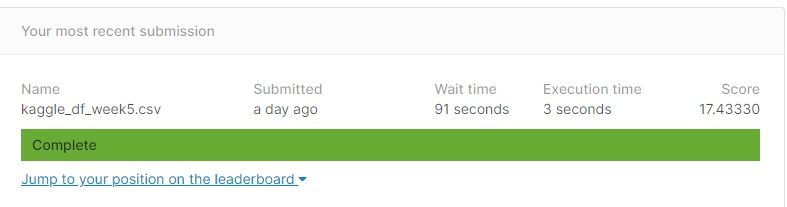

In [50]:
from IPython.display import Image
Image(filename='kaggle_week6.jpg', width=1000)